##生成識別モデル
一般化線形モデルの関数形式を用に仮定し、最尤法を用いてパラメータ推定する

勾配法
- IRLS
- 最急勾配法
- 確率勾配法

-　固定基底関数


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle

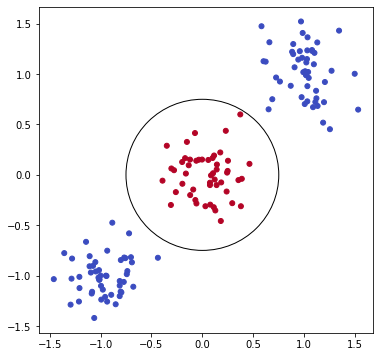

In [7]:
#クラス1: x^2+y^2< 0.75
#クラス2: x^2+y^2 >0.75

N = 50
mu1 = [0,0]
mu2 = [-1,-1]
mu3 = [1,1]
sigma1 = sigma2 = sigma3 = np.eye(2) * 0.05

data1 = np.random.multivariate_normal(mu1, sigma1, size=N) #(N,2)
data2 = np.random.multivariate_normal(mu2, sigma2, size=N) #(N,2)
data3 = np.random.multivariate_normal(mu3, sigma3, size=N) #(N,2)
data = np.concatenate((data1, data2, data3), axis=0) #(3N,2)

train_x = data[:, 0]
train_y = data[:, 1]
train_t = train_x**2 + train_y**2 < 0.75 # (3N,) type=bool

plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], c=train_t, s=25, cmap=cm.coolwarm)

circle = plt.Circle((0,0), 0.75, fill=False)
plt.gcf().gca().add_artist(circle)
plt.show()

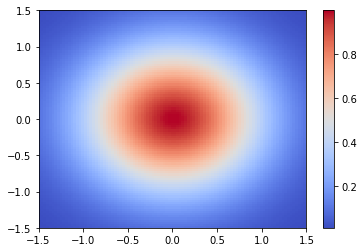

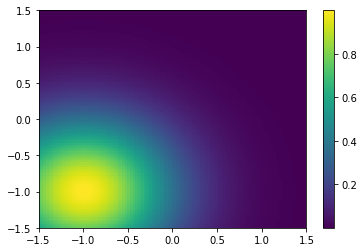

In [12]:
gamma = 1

def gaussian_basis(x, y, cx, cy):
  """
  ガウス基底パラメータ

  """
  return np.exp( - ((x-cx)**2 + (y-cy)**2) * gamma )

phi1 = gaussian_basis(train_x, train_y, 0, 0)
phi2 = gaussian_basis(train_x, train_y, -1, 1)

N = 100
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, N), np.linspace(-1.5, 1.5, N))
Z1 = np.vectorize(gaussian_basis)(X,Y, np.zeros(N), np.zeros(N))
Z2 = np.vectorize(gaussian_basis)(X,Y, -np.ones(N), -np.ones(N))
plt.pcolor(X, Y, Z1, cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.pcolor(X,Y,Z2)
plt.colorbar()
plt.show()

線形分離可能に変換できた


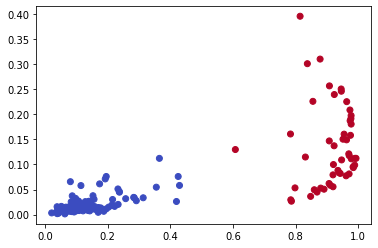

In [13]:
plt.scatter(phi1, phi2, c=train_t, cmap=cm.coolwarm)
plt.show()

##4.3.2　ロジスティック回帰



0


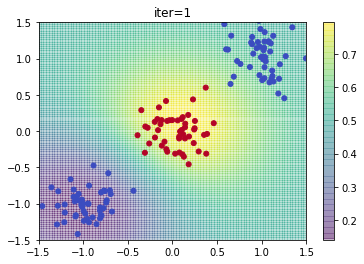

In [20]:
def sigmoid(x):
  """
   シグモイド関数
  """
  return 1/(1+np.exp(-x))

w = np.array([0,0])
e = 0.1 #学習率
count = 0

def phi(x,y):
  """
    Phi-function:
     -return (M,N)
  """
  return np.array( [gaussian_basis(x,y,0,0), gaussian_basis(x,y,-1,-1)])

Phi = phi(train_x, train_y) # (M,N)

for i in range(200):
  y = sigmoid(w@Phi)
  w = w - e * Phi@(y - train_t)
  count += 1
  if LA.norm(Phi.dot(y - train_t)):
    print(i)
    break

f = lambda x, y: sigmoid(w@phi(x,y))

def graph(f):
  X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
  Z = np.vectorize(f)(X,Y)
  plt.xlim(-1.5, 1.5)
  plt.ylim(-1.5, 1.5)
  plt.pcolor(X,Y,Z, alpha=0.3)
  plt.colorbar()
  plt.scatter(train_x, train_y, c=train_t, s = 25, cmap=cm.coolwarm)
  plt.title("iter="+str(count))
  plt.show()

graph(f)

↑足りない…　基底関数を増やす

(25, 150)


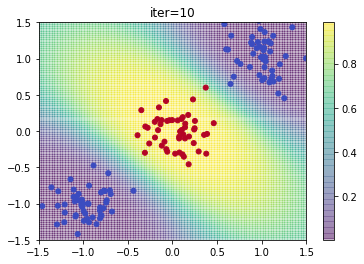

In [22]:
e = 0.1
basis_num = 5
dims = basis_num ** 2

w = np.zeros(dims) #(dim,)
count = 0

basis_center = [(x,y) for x in np.linspace(-1.5, 1.5, basis_num)
                      for y in np.linspace(-1.5, 1.5, basis_num)] # (basis_num, 2)
def phi(x,y):
  return np.array([gaussian_basis(x,y,cx,cy) for cx,cy in basis_center])

#計画行列
Phi = phi(train_x, train_y) #(M,N)
print(Phi.shape)

for i in range(10):
  y = sigmoid(w@Phi)
  w = w - e * Phi@(y-train_t)
  count += 1

f = lambda x,y: sigmoid(w@phi(x,y))

graph(f)

反復再重み付け最小二乗法

(25, 150)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


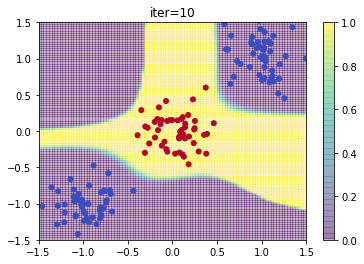

In [58]:
w = np.zeros(dims) # (dim,)
count = 0

Phi = phi(train_x, train_y) #(dim, N)
print(Phi.shape)

y = sigmoid(w@Phi) #(N,)

for i in range(10):
  y = sigmoid(w@Phi)
  R = np.diag(y*(1-y))
  w = w + LA.solve(Phi.dot(R).dot(Phi.T), Phi.dot(train_t - y))
  count += 1

f = lambda x,y: sigmoid(w.dot(phi(x,y)))

graph(f)

確率的勾配降下法

(25, 150)


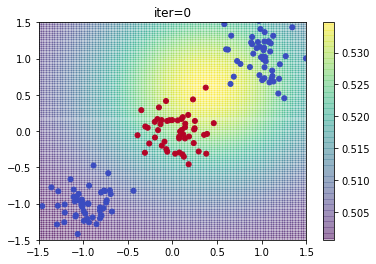

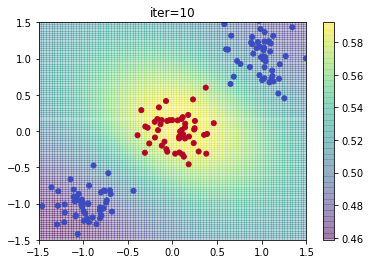

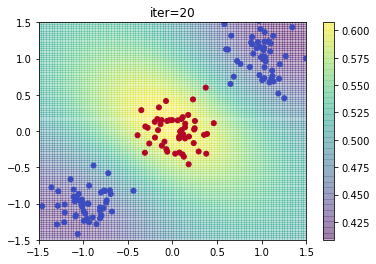

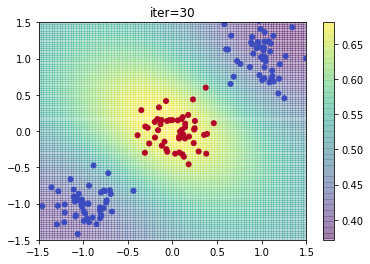

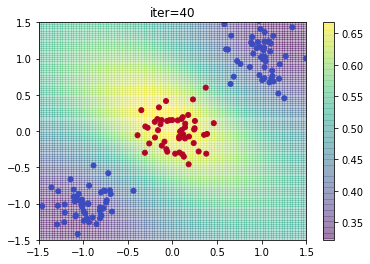

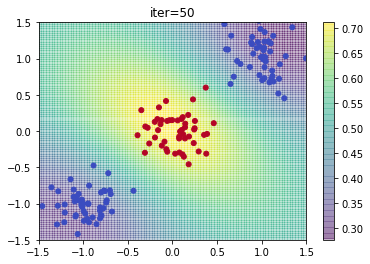

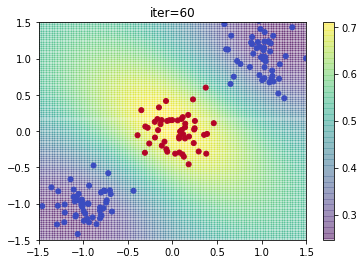

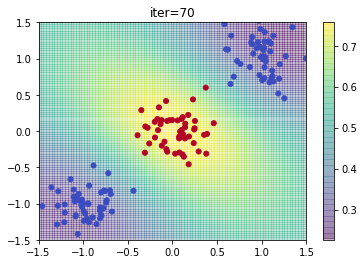

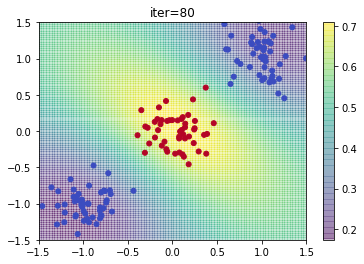

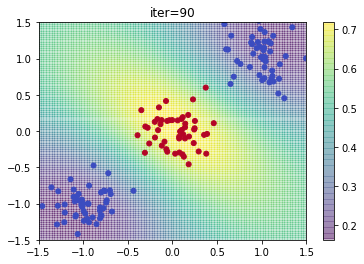

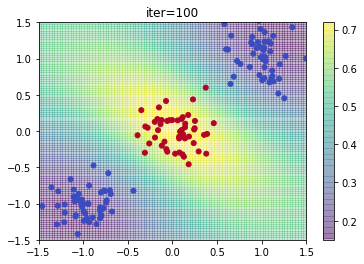

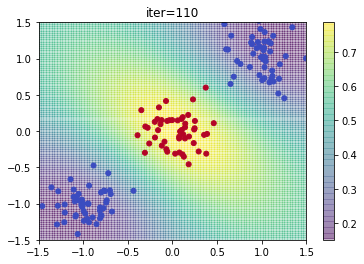

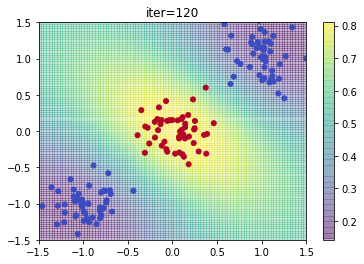

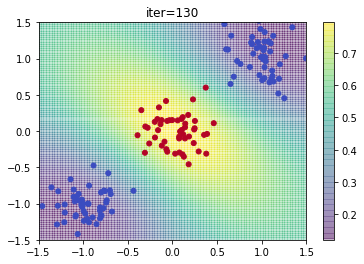

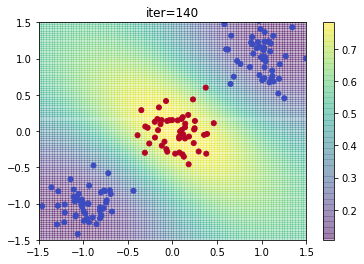

In [63]:
N = 150
e = 0.1

w = np.zeros(dims) #(dim,)
count = 0

Phi = phi(train_x, train_y) # (dim, N)
print(Phi.shape)

for i in range(1):
  train_x, train_y, train_t = shuffle(train_x, train_y, train_t)
  for j in range(N):
    w = w + e * (train_t[j] - sigmoid(w@phi(train_x[j], train_y[j])))*phi(train_x[j], train_y[j])
    if j%10 == 0:
      f = lambda x, y: sigmoid(w@phi(x,y))
      graph(f)
    count += 1